# **Image Classification with Keras**

Hey! I'm [Jason](https://github.com/jasonwu2153), and I'm a junior @Yale majoring in CS. This notebook is my workspace for messing around with Tensorflow's [Image Classification Tutorial](https://www.tensorflow.org/tutorials/images/classification). I'm pretty new to ML and wanted to play with Keras a bit. If you want to mess around with the tutorial yourself, click on the link above! Note that this notebook is pretty much the exact same as Tensorflow's tutorial, but I've added a couple of notes here and there to help fill in any gaps in ML knowledge that I needed to fully understand the concepts.

### **Import TensorFlow and Other Libraries**

First, we are just installing the libraries needed. If you are running this from my [GitHub repo](https://github.com/jasonwu2153/flower-image-classifier-tutorial), I've included a Pipfile in the root directory that can be used to install all of these dependencies. Most of the libraries below are pretty straightforward. This tutorial uses the [Keras Sequential Model](https://keras.io/guides/sequential_model/), which is just a **plain stack of layers** where each layer has **exactly one input tensor and one output tensor**. There are more details about this in the previous link.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

### **Download & Explore Dataset**

Tensorflow's tutorial comes with a dataset of 3,700 flower images organized with the dir structure below. Since there are so many images, I have not added them as a part of the GitHub repository. To use them, we will need to download them.

As I mentioned before, I am a ML newbie so going to be explaining even trivial library functions here. To download the files, we use Keras's [`get_file`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This downloads a file from a URL if it is not already in the cache. After the download, it returns the path to the downloaded file. We also use Python's [`pathlib`](https://docs.python.org/3/library/pathlib.html) library to instantiate a concrete path.

The Keras `get_file` function saves this dataset to `~/.keras/datasets` on whatever machine you are running this on as `~/.keras/datasets/fname`. This directory is cached so even if this gets called again it shouldn't create a duplicate set.

In [62]:
from pathlib import Path
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = Path(data_dir)

Now that the data has been downloaded, we can verify that we have around 3,700 images for this tutorial. To do this, we will use pathlib's `Path.glob` module. This module finds all pathnames matching a pattern. Since all the files are `jpg`, files, we can set our pattern as `*/*.jpg` to recursively find all `jpg` file paths, and count them.

In [63]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


We can then open some of these images by using the `PIL` library.

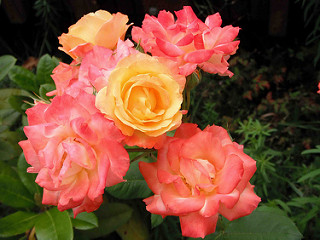

In [64]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

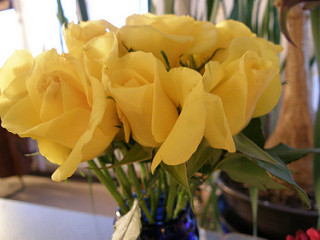

In [65]:
PIL.Image.open(str(roses[1]))

And we can also check out some tulips.

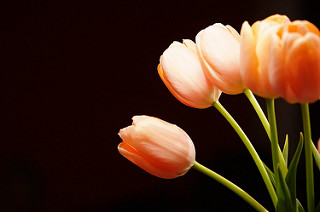

In [66]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

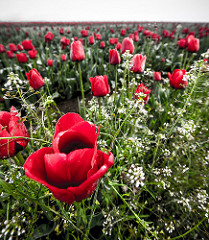

In [67]:
PIL.Image.open(str(tulips[1]))

### **Load Using keras.preprocessing**

Now that we have all of these images, we need to preprocess them to convert them into a dataset we can use for our model. To accomplish this, we will use `image_dataset_from_directory` utility in keras. This will very easily take us from a directory of images on a disk to `tf.data.Dataset`.

#### **Create a Dataset**

First, we will define parameters for the loader.

In [68]:
batch_size = 32
img_height = 180
img_width = 180

It is also good practice to use a validation split when we develop our model. As a newbie to ML, I had no idea what a validation split was so here is a simple breakdown. For ML, there are 3 main phases:

1. Training Phase: Train your model with a ton of data.
2. Validation/Test Phase: Test how good our trained model is.
3. Application Phase: Apply our model to the real world.

A validation split simply defines a ratio of the data to be used for phase 1, and phase 2. If we have a validation split of `0.2` for example, it means 20% of the dataset will be used for phase 2, and the remaining 80% will be used for phase 1. For this tutorial, we will use this validation split.

In addition, the call to `preprocessing.image_dataset_from_directory` has something called `batch_size`. This is basically the number of images we will feed to our network each round of the training phase. This [StackOverflow Post](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network) explains this super well, but the gist is that after each batch, we adjust. The smaller the batch, the less accurate the estimation of the gradient will be (because it will have a lot of fluctuation between rounds). However, smaller batches take less memory and result in faster training.

In [69]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [70]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can find the class names in the `class_names` attribute on the dataset class. These are the directory names in alphabetical order.

In [71]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


#### **Visualize the Data**

We probably want to make sure our data is all good before we continue. To do this, we can plot the first 25 images from the training set and display the class names below each image. This way, we can make sure our data is classified properly before committing to training.

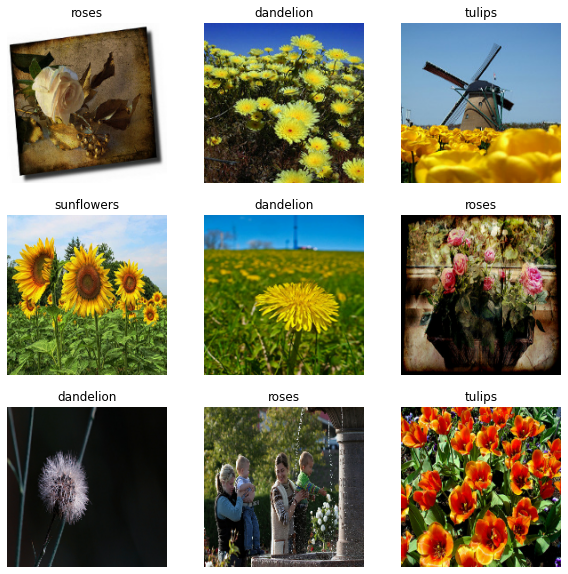

In [72]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### **Configure Dataset For Performance**

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [73]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Standardize the Data**

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [74]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) 

#### **Create the Model**

For these next few steps to make sense, you need to understand how a Convolutional Neural Network works (CNN). [This](https://cs231n.github.io/convolutional-networks/) is a great article by Stanford on this topic.

For the model below, we create a convolution base using a pretty common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers. These layer types are described in the Stanford article I linked above. You probably want to review convolution before actually reading it.

In [75]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Compile the Model**

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Model Summary**

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 22, 22, 64)       

#### **Train the Model**

In [78]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 22s 201ms/step - loss: 1.6272 - accuracy: 0.3361 - val_loss: 1.1748 - val_accuracy: 0.5381
Epoch 2/10
92/92 [==============================] - 18s 195ms/step - loss: 1.0497 - accuracy: 0.5875 - val_loss: 0.9807 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 18s 194ms/step - loss: 0.7790 - accuracy: 0.7138 - val_loss: 0.9244 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 18s 195ms/step - loss: 0.5844 - accuracy: 0.7830 - val_loss: 1.0112 - val_accuracy: 0.6362
Epoch 5/10
92/92 [==============================] - 18s 196ms/step - loss: 0.4206 - accuracy: 0.8430 - val_loss: 1.1236 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 18s 198ms/step - loss: 0.2165 - accuracy: 0.9362 - val_loss: 1.3593 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 18s 195ms/step - loss: 0.1266 - accuracy: 0.9634 - val_loss: 1.4133 - val_accuracy: 0.6240

#### **Train the Model**

Create plots of loss and accuracy on the training and validation sets.

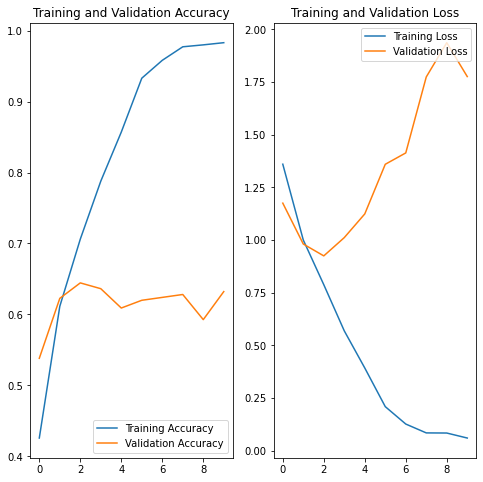

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

#### **Train the Model**

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

#### **Data Augmentation**

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using experimental [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/?version=nightly). These can be included inside your model like other layers, and run on the GPU.

In [83]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

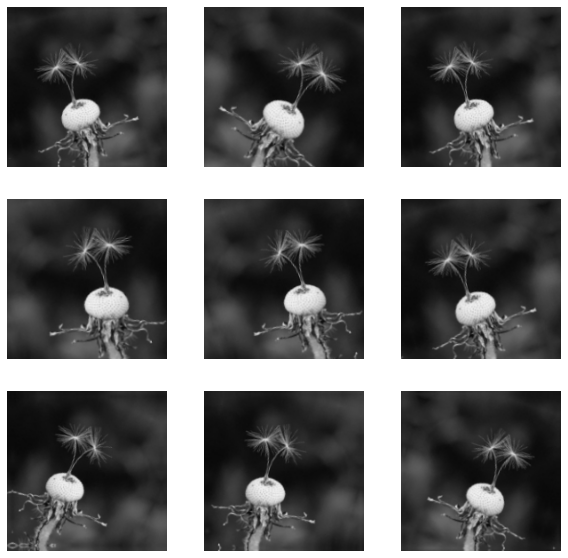

In [85]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

#### **Dropout**

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of regularization.

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [88]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Compile and Train the Model**

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 45, 45, 64)      

In [92]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 20s 214ms/step - loss: 1.4228 - accuracy: 0.3758 - val_loss: 1.0479 - val_accuracy: 0.5708
Epoch 2/15
92/92 [==============================] - 20s 216ms/step - loss: 1.0410 - accuracy: 0.5766 - val_loss: 0.9528 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 20s 212ms/step - loss: 0.9722 - accuracy: 0.6181 - val_loss: 0.9769 - val_accuracy: 0.5995
Epoch 4/15
92/92 [==============================] - 20s 216ms/step - loss: 0.9146 - accuracy: 0.6381 - val_loss: 0.9351 - val_accuracy: 0.6390
Epoch 5/15
92/92 [==============================] - 20s 218ms/step - loss: 0.8318 - accuracy: 0.6742 - val_loss: 0.8794 - val_accuracy: 0.6322
Epoch 6/15
92/92 [==============================] - 20s 220ms/step - loss: 0.7930 - accuracy: 0.6965 - val_loss: 0.8469 - val_accuracy: 0.6703
Epoch 7/15
92/92 [==============================] - 20s 214ms/step - loss: 0.7665 - accuracy: 0.7024 - val_loss: 0.8559 - val_accuracy: 0.6621

#### **Visualize Training Results**

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned.

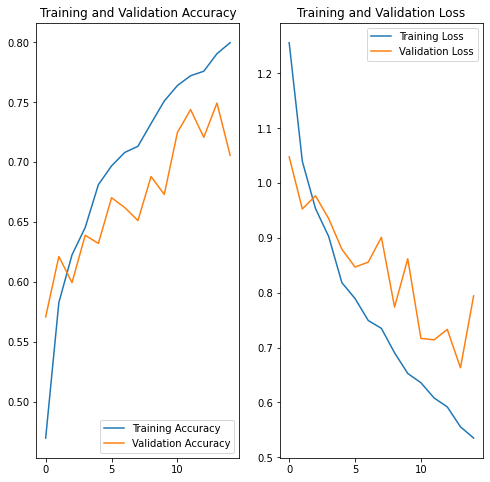

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Predict on New Data**

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [95]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 81.18 percent confidence.
